In [46]:
# config

import os

BASE_PATH = "images"
IMAGES_PATH = BASE_PATH
ANNOTS_PATH = "faces.csv"

BASE_OUTPUT = "output"

MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "faceDetector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

INIT_LR = 1e-4
NUM_EPOCHS = 100
BATCH_SIZE = 32

In [47]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import imutils
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [48]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(ANNOTS_PATH).read().strip().split("\n")
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

[INFO] loading dataset...


In [49]:
# loop over the rows
for row in rows:
	# break the row into the filename and bounding box coordinates
	row = row.split(",")
	(filename, startX, startY, endX, endY) = row
	
    	# derive the path to the input image, load the image (in OpenCV
	# format), and grab its dimensions
	imagePath = os.path.sep.join([IMAGES_PATH, filename])
	image = cv2.imread(imagePath)
	(h, w) = image.shape[:2]
	# scale the bounding box coordinates relative to the spatial
	# dimensions of the input image
	startX = float(startX) / w
	startY = float(startY) / h
	endX = float(endX) / w
	endY = float(endY) / h
	
    # load the image and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	# update our list of data, targets, and filenames
	data.append(image)
	targets.append((startX, startY, endX, endY))
	filenames.append(filename)

In [50]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [51]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [52]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

[INFO] saving object detector model...


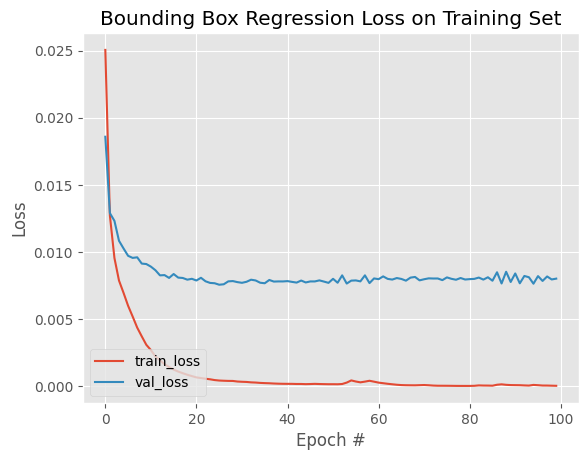

In [53]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

1/1 [==============================] - 0s 151ms/step


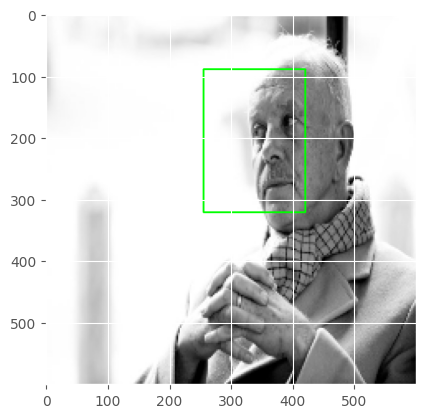

In [59]:
model = load_model(MODEL_PATH)

frame = cv2.imread("./tt.jpg")
image = cv2.resize(frame, (224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
preds = model.predict(image)[0]
(startX, startY, endX, endY) = preds

image = cv2.resize(frame, (224, 224))
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

cv2.rectangle(image, (startX, startY), (endX, endY),
    (0, 255, 0), 2)

# cv2.imshow("Output", image)
plt.figure()
plt.imshow(image)
plt.show()